In [1]:
import numpy as np
import scipy as sp
from numpy import random
from random import choices
import matplotlib.pyplot as plt
import levy
# import plotly.express as px

Replicating the experiment conducted by Daw et.al. (2006): https://www.nature.com/articles/nature04766#Sec3

In [75]:
class Bandits:
    def __init__(self,total_time):
        self.options = 4            # Number of options
        self.sigma = 4              # Variance of sampled payoff from option
        self.decay = 0.9836         # Decay constant of expected payoff RW
        self.decay_centre = 50      # Decay centre of expected payoff RW
        self.sigma_noise = 2.8      # Variance of expected payoff RW
        self.time = total_time      # Total simulation time

    def sample(self,mu):
        # Sample from input mean and constant variance
        return random.normal(mu,self.sigma)
    
    def genMeans(self,starting_var):
        # Generate the mean payoff according to a decaying Gaussian random walk (what is decaying?)
        noise = random.normal(0,self.sigma_noise,(self.options,self.time))   # Preallocating Gaussian noise for payoff diffusion
        payoff0 = np.round(random.normal(50,starting_var,(self.options,1)))            # Defining expected payoffs for step 1
        payoff = np.zeros([self.options,self.time])                          # Preallocating payoff walker
        payoff[:,0] = np.transpose(payoff0)
        for t in range(1,self.time):        # Loop over time and generate expected payoff RW
            payoff[:,t] = self.decay*payoff[:,t-1] + (1-self.decay) * self.decay_centre + noise[:,t]
        return payoff

    def findRegret(self,payoff,result):
        optimal_scores = np.zeros(self.time)
        optimal_choices = np.zeros(self.time)
        for t in range(self.time):
            chosen = np.argmax(payoff[:,t])
            # optimal_scores[t] = self.sample(payoff[chosen,t])
            optimal_scores[t] = payoff[chosen,t]
            optimal_choices[t] = chosen
        regret = 1 - result/sum(optimal_scores)
        return regret, optimal_scores, optimal_choices

    def exploit(self,payoff,trials):
        scores = np.zeros([trials,self.time])                               # Initialise score history
        scores[:,range(4)] = [self.sample(payoff[range(4),0]) for _ in range(trials)]     # Sample from each option once
        chosen = np.argmax(scores,1)
        for t in range(4,self.time):
            scores[:,t] = self.sample(payoff[chosen,t])
        return np.sum(scores,1)

    def softmax(self,payoff,temp,rec,trials):
        scores = np.zeros([trials,self.time])
        history = {idx: np.zeros([trials,self.time]) for idx in range(4)}
        history_choices = np.zeros([trials,self.time])
        for option in history:
            scores[:,option] = self.sample(np.zeros(trials) + payoff[option,0])
            history[option][:,option] = scores[:,option]
            history_choices[:,option] = np.zeros(trials) + option
        for t in range(4,self.time):
            expected_rewards = np.transpose([np.sum(history[option],1)/np.count_nonzero(history[option],1) for option in history])/temp
            weights = np.exp(expected_rewards) / np.sum(np.exp(expected_rewards),1).reshape([trials,1])
            chosen = (np.random.rand(len(weights),1) < weights.cumsum(axis=1)).argmax(axis=1)      # Selecting from probabilities
            scores[:,t] = self.sample(payoff[chosen,t])
            for i,c in enumerate(chosen):   # Updating history with scores
                history[c][i,:] = history[c][i,:] * rec     # Multiply in recent information bias for chosen option
                history[c][i,t] = scores[i,t]
            history_choices[:,t] = chosen
            # for option in history:      # Multiplying in recent information bias: Performance decreases?
            #     history[option] = history[option] * rec
        return np.sum(scores,1),history_choices, history

    def softmax_uncertainty(self,payoff,temp,rec,n,trials):
        # Initialising scores and recording structures
        scores = np.zeros([trials,self.time])
        history = {idx: np.zeros([trials,self.time]) for idx in range(4)}
        history_choices = np.zeros([trials,self.time])
        for option in history:
            scores[:,option] = self.sample(np.zeros(trials) + payoff[option,0])
            history[option][:,option] = scores[:,option]
            history_choices[:,option] = np.zeros(trials) + option

        # Actual loop starting here.
        for t in range(4,self.time):
            mu_rewards = np.transpose([np.sum(history[option],1)/np.count_nonzero(history[option],1) for option in history])     # Mean of history per option
            std_rewards = [np.sqrt((np.sum((history[option] - mu_rewards[:,option].reshape(trials,1))**2,1) - mu_rewards[:,option]**2 
                    * (t-np.count_nonzero(history[option],1)))/np.count_nonzero(history[option],1)) for option in history]
            metric_rewards = (mu_rewards + n*np.transpose(std_rewards))/temp
            
            # Need to add uncertainty bonus to ^: just + n*SD[option], where n is some number of SDs.
            weights = np.exp(metric_rewards) / np.sum(np.exp(metric_rewards),1).reshape([trials,1])
            chosen = (np.random.rand(len(weights),1) < weights.cumsum(axis=1)).argmax(axis=1)      # Selecting from probabilities
            scores[:,t] = self.sample(payoff[chosen,t])
            for i,c in enumerate(chosen):
                history[c][i,:] = history[c][i,:] * rec     # Multiply in recent information bias for chosen option
                history[c][i,t] = scores[i,t]
            history_choices[:,t] = chosen
        return np.sum(scores,1),history_choices


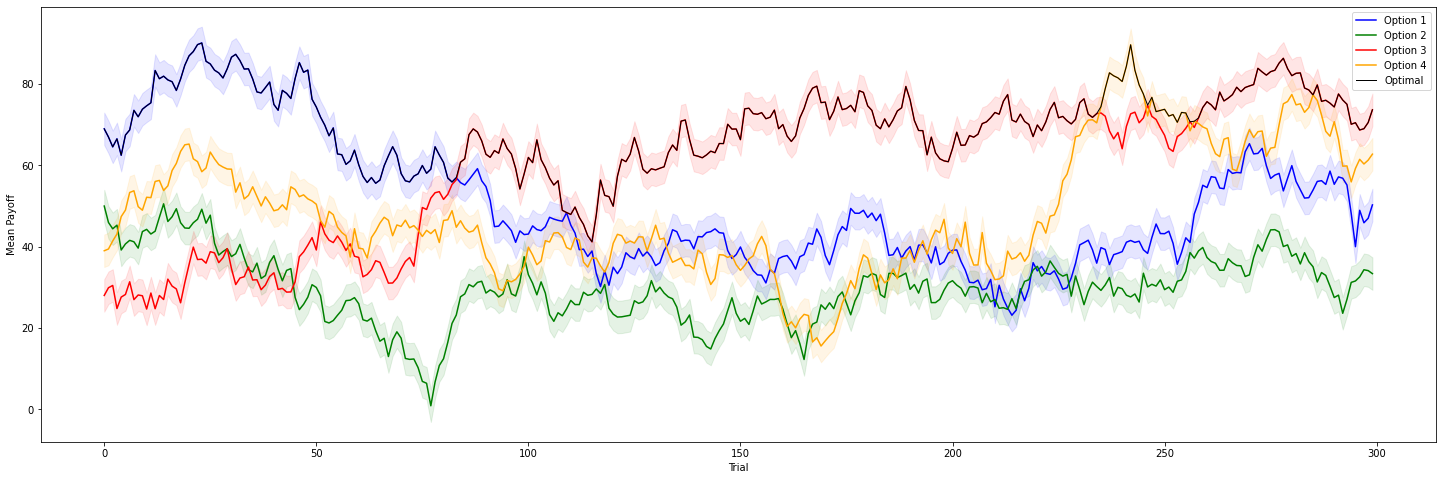

In [102]:
total_time = 300
simu = Bandits(total_time)
# payoffs = simu.genMeans(15)
# np.savetxt('payoffs.csv',payoffs,delimiter=',')
payoffs = np.genfromtxt('payoffs4.csv',delimiter=',')
[_, optimal_scores,_] = simu.findRegret(payoffs,0)


# Plotting payoff distribution with 1 SD error range + optimal picking overlaid
fig,ax = plt.subplots(figsize=(25,8))
colors = ['blue','green','red','orange']
for i in range(len(payoffs)):
    plt.plot(range(total_time),payoffs[i,:], color=colors[i], label='Option '+str(i+1))                
    plt.fill_between(range(total_time),payoffs[i,:]-simu.sigma, payoffs[i,:]+simu.sigma,color=colors[i],alpha=0.1)
plt.plot(range(total_time),optimal_scores,linewidth=1, color='black', label='Optimal')        # Plotting optimal score

plt.xlabel('Trial')
plt.ylabel('Mean Payoff')
plt.legend()
plt.show()

In [166]:
exploit_reward = simu.exploit(payoffs,10000)
[exploit_regret, _, optimal_choices] = simu.findRegret(payoffs,exploit_reward)
print('Pure exploit Mean Regret: %s'% np.mean(exploit_regret),', Std: %s'% np.std(exploit_regret))
unique, counts = np.unique(optimal_choices, return_counts = True)
print('Proportions sampled (optimal):   ',(', ').join([colors[int(unique[i])] +': '+str(round(counts[i]/sum(counts),2)) for i in range(len(counts))])+'\n')

softmax_reward, softmax_choices,softmax_history = simu.softmax(payoffs,3.55,0.99,10000)
[softmax_regret, _, _] = simu.findRegret(payoffs,softmax_reward)
print('Pure Softmax Mean Regret: %s'% np.mean(softmax_regret),', Std: %s'% np.std(softmax_regret))
unique, counts = np.unique(softmax_choices, return_counts = True)
print('Proportions sampled (softmax):   ',(', ').join([colors[int(unique[i])] +': '+str(round(counts[i]/sum(counts),2)) for i in range(len(counts))])+'\n')

softmaxU_reward, softmaxU_choices = simu.softmax_uncertainty(payoffs,4,0.01,0.99,1000)
[softmaxU_regret, _, _] = simu.findRegret(payoffs,softmaxU_reward)
print('Softmax + IB Mean Regret: %s'% np.mean(softmaxU_regret),', Std: %s'% np.std(softmaxU_regret))
unique, counts = np.unique(softmaxU_choices, return_counts = True)
print('Proportions sampled (softmax + IB):  ',(', ').join([colors[int(unique[i])] +': '+str(round(counts[i]/sum(counts),2)) for i in range(len(counts))])+'\n')
# IB is marginally better for payoffs requiring more exploration, and is much worse for payoffs requiring more exploitation

Pure exploit Mean Regret: 0.2806911444583664 , Std: 0.007357490430180466
Proportions sampled (optimal):    blue: 0.28, red: 0.65, orange: 0.07

Pure Softmax Mean Regret: 0.08679199036799513 , Std: 0.025007703395687822
Proportions sampled (softmax):    blue: 0.39, green: 0.02, red: 0.4, orange: 0.19

Softmax + IB Mean Regret: 0.09217942248015092 , Std: 0.01682136298598382
Proportions sampled (softmax + IB):   blue: 0.37, green: 0.03, red: 0.4, orange: 0.2



In [162]:
# Optimise temperature selection
regret_list = np.zeros(20)
temps = np.linspace(3.5,4,20)
for i in range(20):
    softmax_reward, softmax_choices,_ = simu.softmax(payoffs,temps[i],0.99,10000)
    [softmax_regret, _,_] = simu.findRegret(payoffs,softmax_reward)
    unique, counts = np.unique(softmax_choices, return_counts = True)
    regret_list[i] = np.mean(softmax_regret)
optimal_temp = temps[np.argmin(regret_list)]
print('Optimal temp: ', optimal_temp)
print('Softmax Mean Regret: %s'% regret_list[np.argmin(regret_list)]) # 3.2632: 0.1223


Optimal temp:  3.5526315789473686
Softmax Mean Regret: 0.08640165804384535


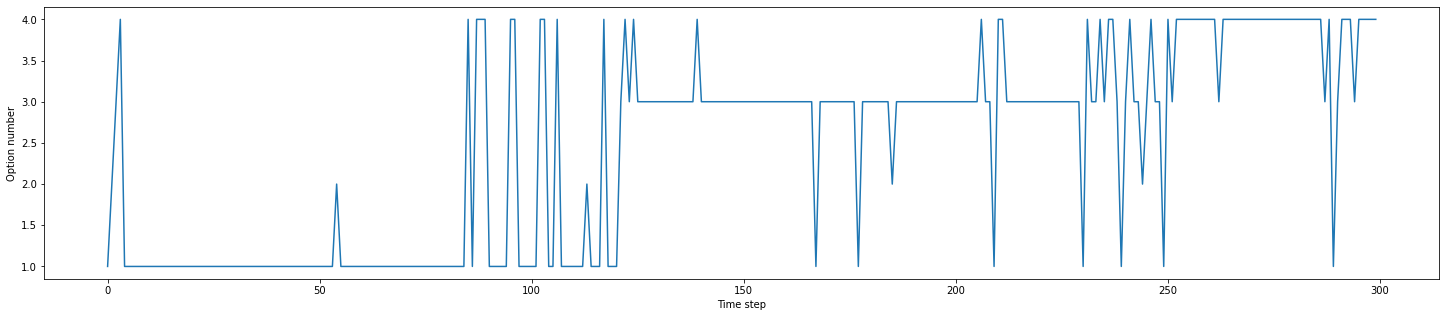

In [155]:
fig,ax = plt.subplots(figsize=(25,5))
trial = 100
plt.plot(softmax_choices[trial,:]+1) # getting into range 1,2,3,4
plt.xlabel('Time step')
plt.ylabel('Option number')
plt.show()

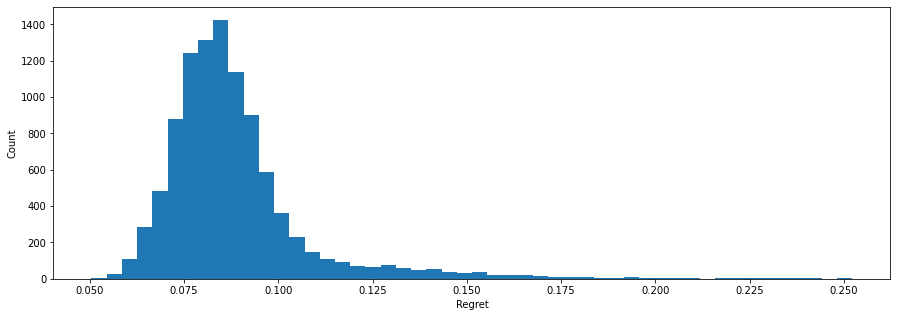

0.08447355437587611

In [157]:
fig,ax = plt.subplots(figsize=(15,5))
plt.hist(softmax_regret,50) 
plt.xlabel('Regret')
plt.ylabel('Count')
plt.show()
np.median(softmax_regret)